In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
from PIL import Image, ImageFile
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from tqdm.auto import tqdm
from torch.utils import data as data_utils
from torchvision import datasets, models, transforms
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader, random_split, Dataset, SubsetRandomSampler

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = '/BTS2023/gigajini/BTS/dataset'
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomAffine(1, shear = 1),
    # transforms.RandomPerspective(),
    # transforms.RandomInvert(),
    transforms.RandomEqualize(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root=data_dir + '/train', transform = train_transform)
test_dataset = datasets.ImageFolder(root=data_dir + '/test', transform = test_transform)

In [3]:
# train_dataset.targets = [1 if label == 0 else 0 for label in train_dataset.targets]
# test_dataset.targets = [1 if label == 0 else 0 for label in test_dataset.targets]
# print(train_dataset.targets)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

## random_split
# train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# print(f'train_size : {len(train_dataset)}')
# print(f'val_size : {len(val_dataset)}')
# print(f'test_size : {len(test_dataset)}')

## StartifiedShuufleSplit
sss = StratifiedShuffleSplit(n_splits = 1, test_size = val_size, random_state = 42)
train_indices, val_indices = next(sss.split(train_dataset, train_dataset.targets))
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [4]:
# train_loader = DataLoader(train_dataset, batch_size = 32)
# val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)
train_loader = DataLoader(train_dataset, batch_size = 32, sampler = train_sampler)
val_loader = DataLoader(train_dataset, batch_size = 32, sampler = val_sampler)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

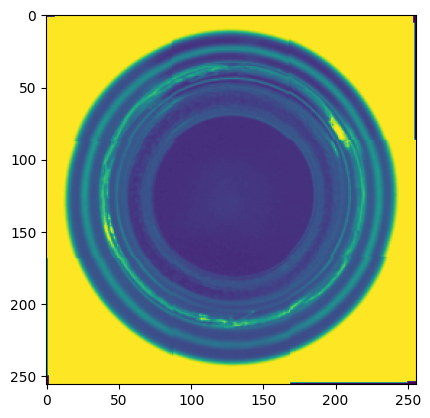

In [5]:
image, label = next(iter(train_loader))
image.shape, label.shape
plt.imshow(image[0, 0, :, :])

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.bencmark = True

seed_everything(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

In [7]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.tanh(nn.functional.softplus(x))

class GIGAJINI(torch.nn.Module):

    def __init__(self):
        super(GIGAJINI, self).__init__()

        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            # nn.ReLU(),
            Mish(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = 3, stride =1, padding = 1),
            nn.BatchNorm2d(64),
            # nn.ReLU(),
            Mish(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            # nn.ReLU(),
            Mish(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            # nn.ReLU(),
            Mish(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer5 = torch.nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(256),
            # nn.ReLU(),
            Mish(),
            nn.MaxPool2d(kernel_size = 2, stride= 2)
        )

        self.layer6 = torch.nn.Sequential(
            nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512),
            # nn.ReLU(),
            Mish(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer7 = torch.nn.Sequential(
            nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512),
            # nn.ReLU(),
            Mish(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.fc =torch.nn.Sequential(
            nn.Linear(512 * 2 * 2, 2, bias = True),
            # nn.ReLU()
            Mish()
        )        
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [8]:
model = GIGAJINI().to(device)
learning_rate = 1e-4
epochs = 50
batch_size = 16
class_weight = torch.tensor([0.1, 0.9])
criterion = torch.nn.CrossEntropyLoss(weight = class_weight).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [9]:
def train(model, train_loader, val_loader, epochs, learning_rate, patience):

    best_loss = float('inf')
    best_model = None
    epochs_without_importvement = 0

    for epoch in range(epochs):
        model.train()
        avg_loss = 0

        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)

            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()

        avg_loss /= len(train_loader)

        val_loss = evaluate(model, val_loader) 

        print(f'Epoch : {epoch + 1}, Train Loss : {avg_loss:.4f}, Validation Loss: {val_loss:.4f}')

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict().copy()
            print('Model Saved')
            epochs_without_importvement = 0

        else:
            epochs_without_importvement += 1

        if epochs_without_importvement >= patience:
            print(f'Early stopping: No improvement in validation loss for {patience} epochs.')
            break

    return best_model

def evaluate(model, dataloader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for X, Y in dataloader:
            X = X.to(device)
            Y = Y.to(device)
            output = model(X)
            loss = criterion(output, Y)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [10]:
patience = 5
best_model = train(model, train_loader, val_loader, epochs, learning_rate, patience)
model.load_state_dict(best_model)

model.eval()
test_loss = 0
correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        test_loss += criterion(output, Y).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(Y.view_as(pred)).sum().item()

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(Y.cpu().numpy())

test_loss /= len(test_loader.dataset)
accuracy = correct / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2%}")

# F1 score 계산
f1_micro = f1_score(all_labels, all_preds, average='micro')
f1_macro = f1_score(all_labels, all_preds, average='macro')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 Score (Micro): {f1_micro:.8f}")
print(f"F1 Score (Macro): {f1_macro:.8f}")
print(f"F1 Score (Weighted): {f1_weighted:.8f}")

# Precision 계산
precision_micro = precision_score(all_labels, all_preds, average='micro')
precision_macro = precision_score(all_labels, all_preds, average='macro')
precision_weighted = precision_score(all_labels, all_preds, average='weighted')
print(f"Precision (Micro): {precision_micro:.8f}")
print(f"Precision (Macro): {precision_macro:.8f}")
print(f"Precision (Weighted): {precision_weighted:.8f}")

# Recall 계산
recall_micro = recall_score(all_labels, all_preds, average='micro')
recall_macro = recall_score(all_labels, all_preds, average='macro')
recall_weighted = recall_score(all_labels, all_preds, average='weighted')
print(f"Recall (Micro): {recall_micro:.8f}")
print(f"Recall (Macro): {recall_macro:.8f}")
print(f"Recall (Weighted): {recall_weighted:.8f}")

# Confusion Matrix 계산
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(cm)

# 분류 리포트 출력
class_names = [str(num) for num in torch.arange(2).tolist()]
classification_rep = classification_report(all_labels, all_preds, target_names=class_names)
print('Classification Report:')
print(classification_rep)

Epoch : 1, Train Loss : 0.1752, Validation Loss: 0.5856
Model Saved
Epoch : 2, Train Loss : 0.0856, Validation Loss: 0.4531
Model Saved
Epoch : 3, Train Loss : 0.0682, Validation Loss: 0.3408
Model Saved
Epoch : 4, Train Loss : 0.0628, Validation Loss: 0.1688
Model Saved
Epoch : 5, Train Loss : 0.0576, Validation Loss: 0.0924
Model Saved
Epoch : 6, Train Loss : 0.0549, Validation Loss: 0.0567
Model Saved
Epoch : 7, Train Loss : 0.0559, Validation Loss: 0.0510
Model Saved
Epoch : 8, Train Loss : 0.0480, Validation Loss: 0.0460
Model Saved
Epoch : 9, Train Loss : 0.0457, Validation Loss: 0.0598
Epoch : 10, Train Loss : 0.0500, Validation Loss: 0.0330
Model Saved
Epoch : 11, Train Loss : 0.0347, Validation Loss: 0.0256
Model Saved
Epoch : 12, Train Loss : 0.0280, Validation Loss: 0.0751
Epoch : 13, Train Loss : 0.0259, Validation Loss: 0.0311
Epoch : 14, Train Loss : 0.0264, Validation Loss: 0.0944
Epoch : 15, Train Loss : 0.0229, Validation Loss: 0.0091
Model Saved
Epoch : 16, Train Loss

In [11]:
torch.save(model, '/BTS2023/gigajini/BTS/GIGAJINI_CNN.pth')